In [1]:
import gensim.downloader as api

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
wv = api.load('word2vec-google-news-300')


In [6]:
import pandas as pd
df = pd.read_json('/content/drive/MyDrive/Data Sets/news_dataset.json')
df.head()

,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS


In [19]:
df.category.value_counts()

,count
category,
CRIME,2500
SPORTS,2500
BUSINESS,2500


In [8]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 691.8 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [10]:

def  preprocess_and_vectorize(text):
  doc = nlp(text)
  filtered_text = []
  for token in doc:
    if token.is_stop or token.is_punct:
      continue
    filtered_text.append(token.lemma_)
  return wv.get_mean_vector(filtered_text)

In [11]:
df['vector_text'] = df['text'].apply(lambda x : preprocess_and_vectorize(x) )

In [12]:
df.head()

,text,category,vector_text
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,"[0.0028300553, 0.010366876, 0.0017567596, 0.02..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,"[0.020606516, 0.023028202, -0.008266339, 0.033..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,"[0.028917346, 0.014135682, 0.0073085385, 0.011..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,"[0.021925448, -0.00023149428, -0.022482838, 0...."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,"[0.036470134, -0.023180826, 0.006566672, 0.030..."


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.vector_text,
    df.category,
    test_size = 0.2,
    random_state=43
)

### **Reshaping X_train And X_test, so as to fit for models**

In [14]:
import numpy as np
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
model = GradientBoostingClassifier()
model.fit(X_train_2d, y_train)

GradientBoostingClassifier()

In [17]:
y_pred = model.predict(X_test_2d)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    BUSINESS       0.90      0.89      0.90       523
       CRIME       0.90      0.90      0.90       492
      SPORTS       0.89      0.89      0.89       485

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



### **Make some Predictions**

In [21]:
news_text = df.text[2]
news_text


'Vegas Taxpayers Could Spend A Record $750 Million On A New NFL Stadium Billionaire Sheldon Adelson wants the stadium to lure the Oakland Raiders to Vegas.'

In [24]:
# Function for news prediction
def predict_news(news_text):
  news_text_vec = preprocess_and_vectorize(news_text)
  if model.predict([news_text_vec]) == "CRIME":
    return "CRIME NEWS"
  elif model.predict([news_text_vec]) == "SPORTS":
    return "SPORTS NEWS"

  else:
    return "BUSINESS NEWS"



In [25]:
predict_news(news_text)


'SPORTS NEWS'

### **Confusion Matrix**

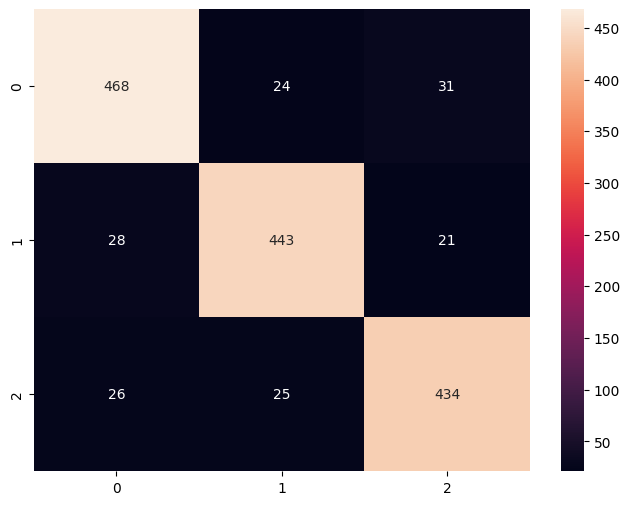

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)

from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()